# Comparing methods of hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from build_data import build_hurricane_data
import build_model
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp
import random

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "v1.0.0, 27 May 2022"

EXP_NAME_LIST = (
                 "intensity431_EPCP48",    
                 # "intensity432_EPCP48",
                 # "intensity433_AL48",
                 )

OVERWRITE_MODEL = False
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Start looping through runs

years(2013,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (157, 1),
 'onehot_train_shape': (1937, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (157, 12),
 'x_train_shape': (1937, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}


/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


'intensity431_EPCP48_2013_bnnshashLL_network_seed_222_rng_seed_222'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization (Normalization)  (None, 12)           25          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 12)           0           ['normalization[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 15)           195         ['dropout[0][0]']                
                          

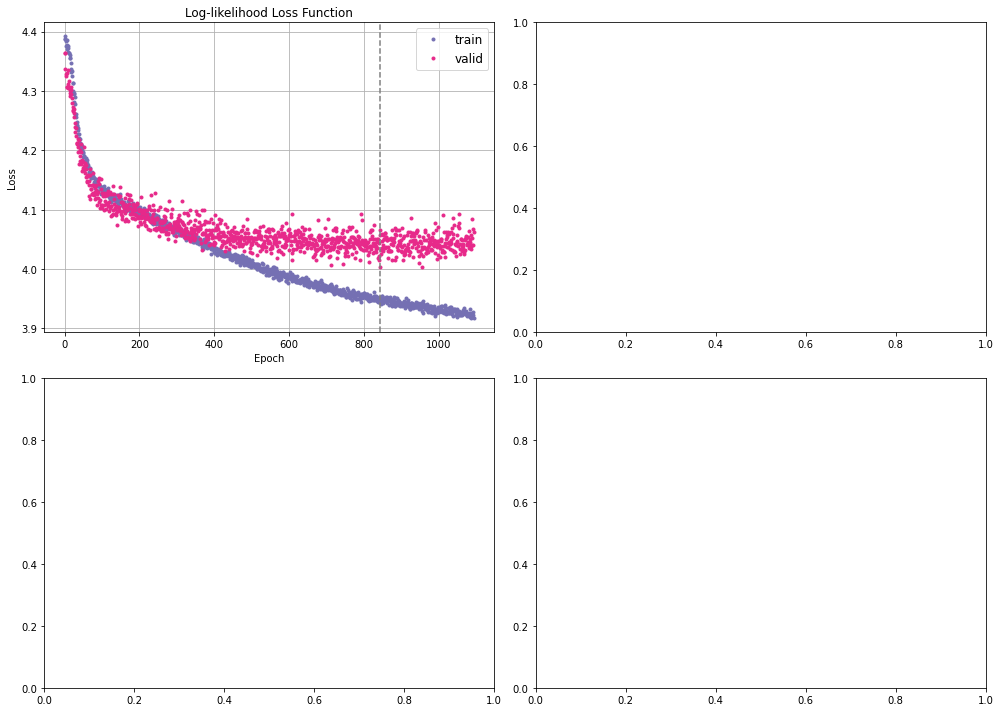

unable to save the model, skipping and saving the weights.
years(2013,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (157, 1),
 'onehot_train_shape': (1937, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (157, 12),
 'x_train_shape': (1937, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}
'intensity431_EPCP48_2013_bnnshashLL_network_seed_333_rng_seed_333'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
              

/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Restoring model weights from the end of the best epoch: 965.
Epoch 01215: early stopping
{'best_epoch': 964,
 'elapsed_time': 35.99916195869446,
 'loss_train': 3.9560916423797607,
 'loss_valid': 4.116937160491943,
 'network_seed': 333}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


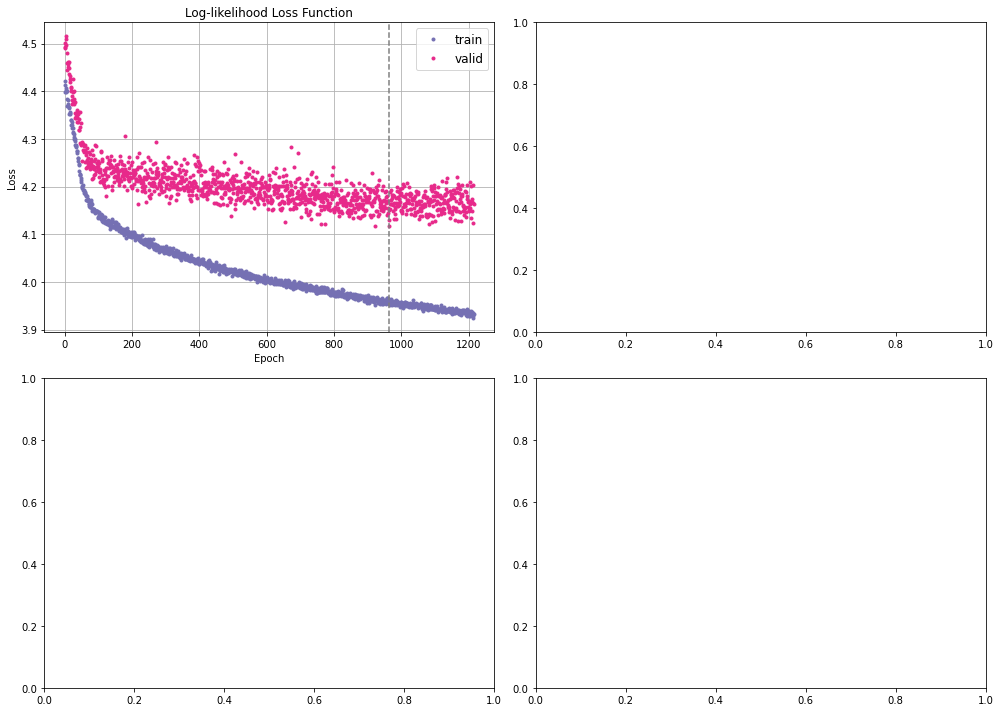

unable to save the model, skipping and saving the weights.
years(2013,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (157, 1),
 'onehot_train_shape': (1937, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (157, 12),
 'x_train_shape': (1937, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}
'intensity431_EPCP48_2013_bnnshashLL_network_seed_416_rng_seed_416'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
              

/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Total params: 446
Trainable params: 421
Non-trainable params: 25
__________________________________________________________________________________________________
Restoring model weights from the end of the best epoch: 2474.
Epoch 02724: early stopping
{'best_epoch': 2473,
 'elapsed_time': 73.81268000602722,
 'loss_train': 3.8837215900421143,
 'loss_valid': 3.9583630561828613,
 'network_seed': 416}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


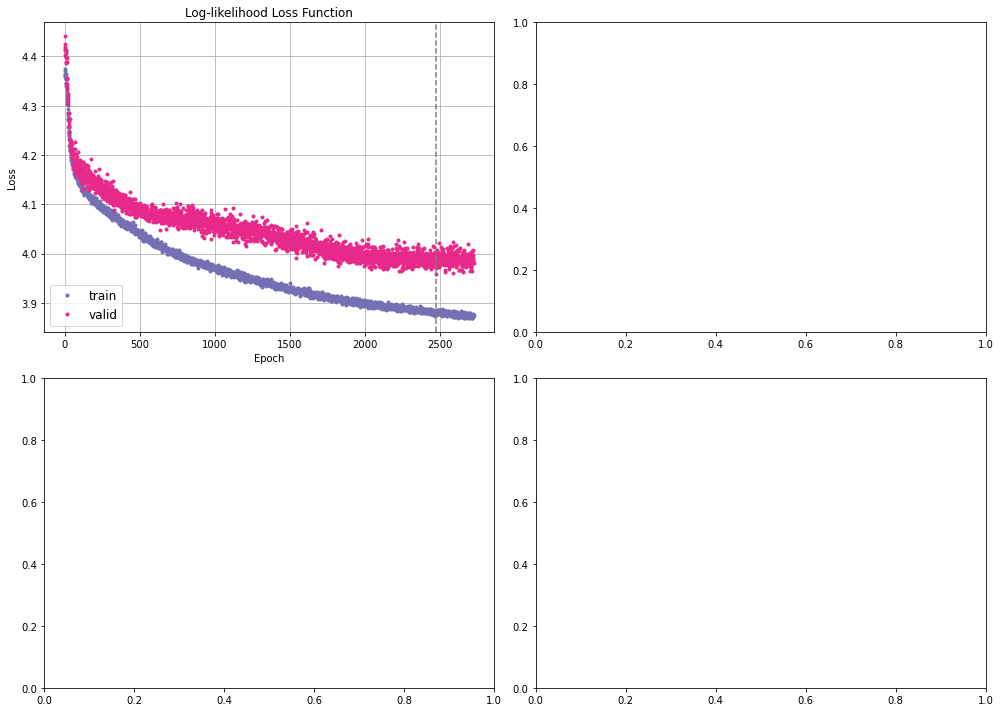

unable to save the model, skipping and saving the weights.
years(2013,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (157, 1),
 'onehot_train_shape': (1937, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (157, 12),
 'x_train_shape': (1937, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}
'intensity431_EPCP48_2013_bnnshashLL_network_seed_599_rng_seed_599'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
              

/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Restoring model weights from the end of the best epoch: 787.
Epoch 01037: early stopping
{'best_epoch': 786,
 'elapsed_time': 30.181084871292114,
 'loss_train': 3.9744246006011963,
 'loss_valid': 3.9624974727630615,
 'network_seed': 599}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


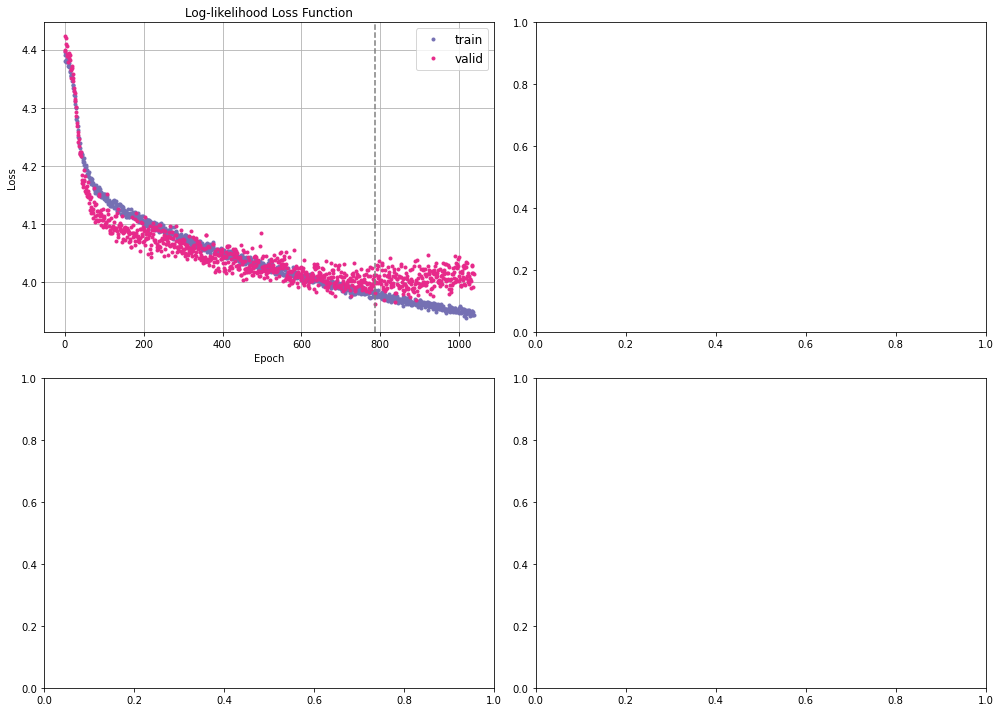

unable to save the model, skipping and saving the weights.
years(2013,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (157, 1),
 'onehot_train_shape': (1937, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (157, 12),
 'x_train_shape': (1937, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}


/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


'intensity431_EPCP48_2013_bnnshashLL_network_seed_739_rng_seed_739'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization (Normalization)  (None, 12)           25          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 12)           0           ['normalization[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 15)           195         ['dropout[0][0]']                
                          

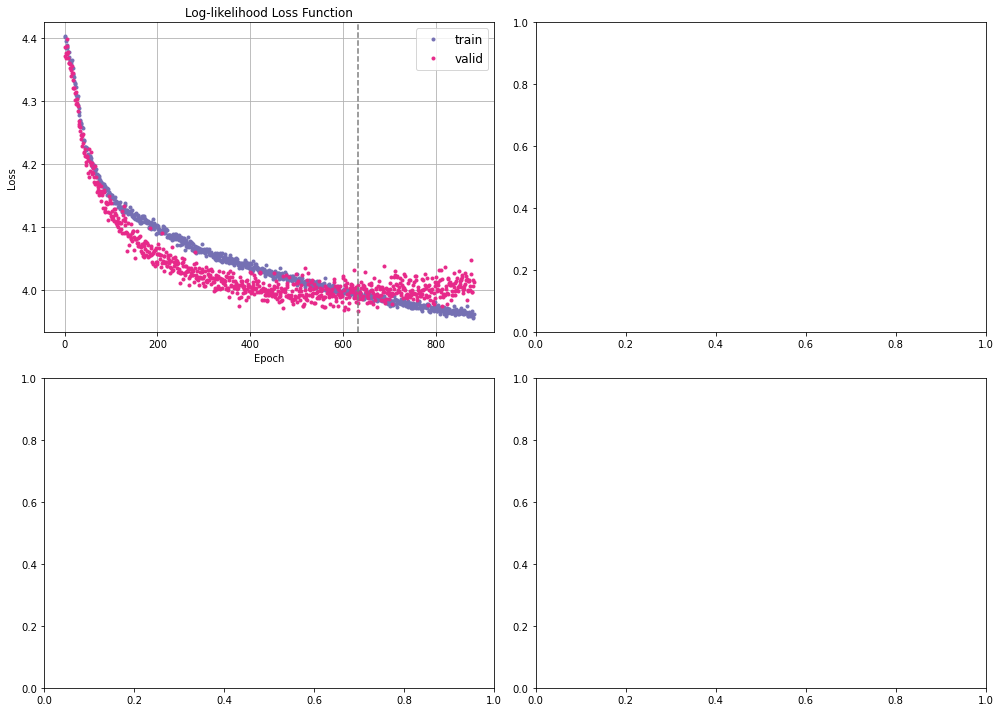

unable to save the model, skipping and saving the weights.
years(2014,) withheld for testing
{'datafile_path': 'data/nnfit_vlist_17-Mar-2022_eab.dat',
 'onehot_test_shape': (368, 1),
 'onehot_train_shape': (1726, 1),
 'onehot_val_shape': (200, 1),
 'x_names': ['NCI',
             'VMAX0',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_test_shape': (368, 12),
 'x_train_shape': (1726, 12),
 'x_val_shape': (200, 12),
 'y_name': ['OBDV']}
'intensity431_EPCP48_2014_bnnshashLL_network_seed_222_rng_seed_222'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
              

/Volumes/GoogleDrive/My Drive/WORK/RESEARCH/2022/hurricane_uqcomparisons/build_data.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_valtest = df_val.append(df_test)
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/eabarnes/miniforge3/envs/env-tfp-2.7/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Restoring model weights from the end of the best epoch: 1003.
Epoch 01253: early stopping
{'best_epoch': 1002,
 'elapsed_time': 32.05016088485718,
 'loss_train': 3.9078099727630615,
 'loss_valid': 3.98764705657959,
 'network_seed': 222}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


In [ ]:
import imp
imp.reload(build_model)

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2013,2022)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')

        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
        
        
        for rng_seed in settings['rng_seed_list']:
            settings['rng_seed'] = rng_seed

            # build the intensity data tensors
            (
                data_summary,        
                x_train,
                onehot_train,
                x_val,
                onehot_val,
                x_test,
                onehot_test,        
                x_valtest,
                onehot_valtest,
                df_train,
                df_val,
                df_test,
                df_valtest,
            ) = build_hurricane_data(DATA_PATH, settings, verbose=1)

            # define the callbacks
            earlystoping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=settings["patience"],
                restore_best_weights=True,
                verbose=1,
            )

            training_callback = TrainingInstrumentation(
                x_train,
                onehot_train,
                interval=50,
            )

            callbacks = [earlystoping_callback, 
                         # training_callback,
                        ]

            # set network seed and train the model
            NETWORK_SEED_LIST = [settings["rng_seed"]]

            for network_seed in NETWORK_SEED_LIST:
                
                # set random seeds
                np.random.seed(rng_seed)
                random.seed(rng_seed)                            
                tf.random.set_seed(network_seed) 

                # Create the model name.
                model_name = (
                    exp_name + "_" + 
                    str(testing_years) + '_' +
                    settings["uncertainty_type"] + '_' + 
                    f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
                )
                pprint.pprint(model_name)

                # Make, compile, and train the model
                tf.keras.backend.clear_session()            
                model = build_model.make_model(
                    settings,
                    x_train,
                    onehot_train,
                    model_compile=True,
                )   
                model.summary()

                # check if the model exists
                model_savename = MODEL_PATH + model_name + "_weights.h5"
                if os.path.exists(model_savename) and OVERWRITE_MODEL==False:
                    print(model_savename + 'exists. Skipping...')
                    continue

                # train the network
                start_time = time.time()
                history = model.fit(
                    x_train,
                    onehot_train,
                    validation_data=(x_val, onehot_val),
                    batch_size=settings["batch_size"],
                    epochs=settings["n_epochs"],
                    shuffle=True,
                    verbose=0,
                    callbacks=callbacks,
                )
                stop_time = time.time()

                # Display the results, and save the model rum.
                best_epoch = np.argmin(history.history["val_loss"])
                fit_summary = {
                    "network_seed": network_seed,
                    "elapsed_time": stop_time - start_time,
                    "best_epoch": best_epoch,
                    "loss_train": history.history["loss"][best_epoch],
                    "loss_valid": history.history["val_loss"][best_epoch],
                }
                pprint.pprint(fit_summary, width=80)
                plot_history(history, model_name)

                save_model_run(
                    data_summary,
                    fit_summary,
                    model,
                    MODEL_PATH,
                    model_name,
                    settings,
                    __version__,
                )

In [ ]:
2+2

In [ ]:
# import shash_tfp
# y_true = 0.
# mu = 0.
# sigma = 1.
# gamma = 0.
# tau = 1.

# dist = shash_tfp.Shash(mu, sigma, gamma, tau)
# value = dist.quantile(.25)
# # value = dist.log_prob(y_true).numpy()
# print(value)

# # shash_tfp.Shash.log_prob(y_true, mu, sigma, gamma, tau)

# import shash_tfp
# import tfp

# y_true = 0.
# mu = 0.
# sigma = 1.
# gamma = 0.
# tau = 1.

# dist = tfp.distributions.SinhArcsinh(mu, sigma, gamma, tau)
# value = dist.mean()
# print(value)

# dist = shash_tfp.Shash(mu, sigma, gamma, tau)
# value = dist.mean()
# print(value)
